# Evaluating approaches to handle missing data in context of machine learning problems

### Abhijith Mandya
### Rohan Bapat
### Sally Gao



In [1]:
import pandas as pd
import numpy as np

# Import RandomForestRegressor from scikitlearn to predict missing values using Random Forests
from sklearn.ensemble import RandomForestRegressor

# Import RandomForestRegressor from scikitlearn to predict missing values using Linear Regression
from sklearn.linear_model import LinearRegression

# Import train_test_split for cross-validation
from sklearn.model_selection import train_test_split

# Import LogisticRegression from scikitlearn to classify test values using Logistic Regression
from sklearn.linear_model import LogisticRegression

# Import accuracy_score from scikitlearn to determine accuracy of test prediction
from sklearn.metrics import accuracy_score

# Import RandomForestClassifier from scikitlearn to classify test values using RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
import random
import statistics
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir("C:\\Users\\Rohan Bapat\\Documents\\Classes\\CS 5010\\Project\\train")
# INPUT DATA
#--------------

# Add path of your data on your local drive
df = pd.read_csv("train.csv")

In [3]:
# DATA CLEANING
#-----------------

# Remove outliers. Those rides that were greater than 6 hours
df = df[df.trip_duration < 21600]

# Remove erroneous observations where passenger_count = 0 
df = df[df.passenger_count > 0]

# Convert string into datetime variable
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')

# Create minute column
df['pickup_minute'] = df['pickup_datetime'].dt.minute
df['dropoff_minutes'] = df['dropoff_datetime'].dt.minute

# Create hour column
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour

# Create day of week column
df['pickup_dow'] = df['pickup_datetime'].dt.weekday
df['dropoff_dow'] = df['dropoff_datetime'].dt.weekday

# Create day of month column
df['pickup_dom'] = df['pickup_datetime'].dt.day
df['dropoff_dom'] = df['dropoff_datetime'].dt.day

# Create month column
df['pickup_month'] = df['pickup_datetime'].dt.month
df['dropoff_month'] = df['dropoff_datetime'].dt.month

# Map 'Y' and 'N' in 'store_and_fwd_flag' as 1 and 0
store_and_fwd_map = {'Y':1,'N':0}
df = df.copy()
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map(store_and_fwd_map)

# Convert numerical day of week into textual format
week = {0:"Sun", 1:"Mon", 2:"Tue", 3:"Wed", 4:"Thur", 5:"Fri", 6:"Sat"}
df["pickup_weekday"] = df["pickup_dow"].map(week)

Mean distance travelled is 2.86
Median distance travelled is nan


C:\Users\Rohan Bapat\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
C:\Users\Rohan Bapat\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Rohan Bapat\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


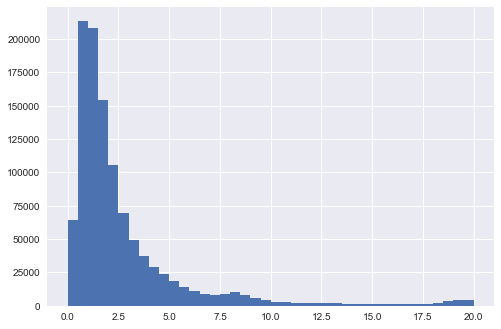

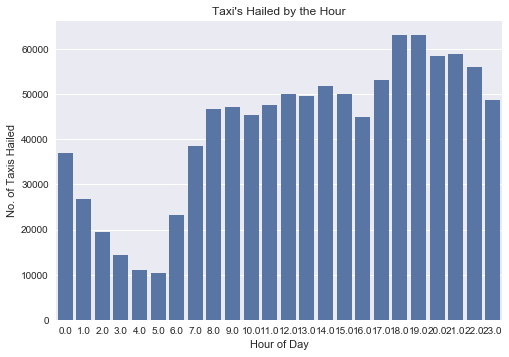

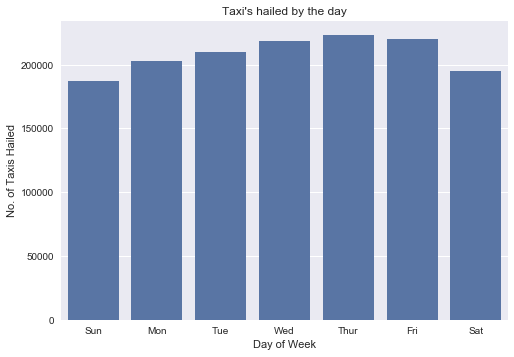

In [28]:
# EXPLORATORY ANALYSIS
#-----------------------

# PART 1 - Estimate the manhattan distance
df['manhattan_distance'] = abs(df.pickup_longitude-df.dropoff_longitude)*68.703 + abs(df.pickup_latitude-df.dropoff_latitude)*55.243

# Print mean and median distance travlled
print("Mean distance travelled is " + str(np.around(np.mean(df['manhattan_distance']),decimals=2)))
print("Median distance travelled is " + str(np.round(np.median(df['manhattan_distance']),decimals=2)))

# Plot histogram of Manhattan distance of all trips taken by cabs
plt.figure()
plt.title = ("Manhattan Distance in Miles")
plt.hist(df['manhattan_distance'], 40, range=[0,20])
plt.show() 

#------------------------------------------------------------------------------------------------

# PART 2 - Visualise variation in taxi pick up time by hour
fig2 = sns.countplot(x="pickup_hour", data=df, color = "b")
fig2.set(xlabel='Hour of Day', ylabel='No. of Taxis Hailed', title = "Taxi's Hailed by the Hour")
sns.plt.show()

# PART 3 - Visualise variation in taxi pick up day by day of week

df2 = df.sort_values('pickup_dow', axis = 0)
df2 = df2.reset_index(drop= True)

fig3 = sns.countplot(x="pickup_weekday", data=df2, color = "b")
fig3.set(xlabel='Day of Week', ylabel='No. of Taxis Hailed', title = "Taxi's hailed by the day")
sns.plt.show() 

In [5]:
# MISSING DATA
#-----------------

# Create missing data
random.seed(123)

# Insert nan values in pickup_hour
nan_pickup_hours = df['pickup_hour'].sample(round(df.shape[0]/3.3)).index
df.loc[nan_pickup_hours,'pickup_hour']=np.nan

# Insert nan values in dropoff_longitude
nan_dropoff_longitude = df['dropoff_longitude'].sample(round(df.shape[0]/4.1)).index
df.loc[nan_dropoff_longitude,'dropoff_longitude']=np.nan

In [15]:
# APPROACHES TO HANDLE MISSING DATA
#--------------------------------------

# Approach 1 - Delete rows with missing values
# Pass only the dataframe as argument
# Returns clean dataframe and the % of rows dropped

def approach1_rem_msg(messy_df):
    
    # Drop entire row containing missing values
    clean_df = messy_df.dropna()
    
    # Calculate % of rows dropped
    rows_dropped = 1 - clean_df.shape[0]/messy_df.shape[0]
    return clean_df, rows_dropped

#------------------------------------------------------------------------------------------------------------------------

# Approach 2 - Impute missing values
# The following function imputes the missing values with mean/median/mode according to arguments passed
# User also has to pass as list the names of columns which have missing values 
# Call function  - approach2_impute_metric(<df>,<"mean">/<"median">/<"mode">,[<'missingcolname1'>,<'missingcolname2'])
# Returns cleaned df and list of imputed values for all columns

def approach2_impute_metric(messy_df, metric, colnames):
    clean_df = messy_df.copy()    
    missing_list = []
    
    # Impute mean
    if metric=="mean":
        for col in colnames:
            
            # Caluclate mean value of required column
            imputenum = messy_df[col].mean()
            
            # Calculate number of observations having missing value
            missing_count = messy_df[col].isnull().sum()
            
            # Create a list of imputed missing values
            missing_list.append([imputenum]*missing_count)
            
            # Impute mean in the missing fields
            clean_df[col] = messy_df[col].fillna(imputenum)            

    if metric=="median":
        for col in colnames:
            
            # Caluclate median value of required column
            imputenum = messy_df[col].median()
            
            # Calculate number of observations having missing value
            missing_count = messy_df[col].isnull().sum()  
            
            # Create a list of imputed missing vales
            missing_list.append([imputenum]*missing_count)
            
            # Impute median in the missing fields
            clean_df[col] = messy_df[col].fillna(imputenum)
    
    if metric=="mode":
        for col in colnames:
            
             # Caluclate mode value of required column
            imputenum = messy_df[col].mode()
            
            # Calculate number of observations having missing valu
            missing_count = messy_df[col].isnull().sum
            
            # Get positions of missing values
            missing_pos = clean_df[col].isnull()
            
            # In case of multiple modes, randomly allocate the modes across missing fields
            clean_df.loc[clean_df[col].isnull(),col] = np.random.choice(imputenum)
            
            # Create missing_list
            missing_list.append(clean_df.loc[missing_pos,col].tolist())    
        
    return clean_df, missing_list
 
#-------------------------------------------------------------------------------------------------------------------------

# Approach 3 - Predict missing values
# The following function predicts missing values using Linear Regression or Random Forests
# User also has to pass as list the names of columns which have missing values 
# Call function  - approach2_impute_metric(<df>,<"Linear Regression">/<"Random Forests">,[<'missingcolname1'>,<'missingcolname2'])
# Returns cleaned df and list of imputed values for all columns
    
def approach3_predict_msg(messy_df, metric, colnames):
    
    # Create X_df of predictor columns
    X_df = messy_df.drop(colnames, axis = 1)
    
    # Create Y_df of predicted columns
    Y_df = messy_df[colnames]
        
    # Create empty dataframes and list
    Y_pred_df = pd.DataFrame(columns=colnames)
    Y_missing_df = pd.DataFrame(columns=colnames)
    missing_list = []
    
    # Loop through all columns containing missing values
    for col in messy_df[colnames]:
    
        # Number of missing values in the column
        missing_count = messy_df[col].isnull().sum()
        
        # Separate train dataset which does not contain missing values
        messy_df_train = messy_df[~messy_df[col].isnull()]
        
        # Create X and Y within train dataset
        msg_cols_train_df = messy_df_train[col]
        messy_df_train = messy_df_train.drop(colnames, axis = 1)

        # Create test dataset, containing missing values in Y    
        messy_df_test = messy_df[messy_df[col].isnull()]
        
        # Separate X and Y in test dataset
        msg_cols_test_df = messy_df_test[col]
        messy_df_test = messy_df_test.drop(colnames,axis = 1)

        # Copy X_train and Y_train
        Y_train = msg_cols_train_df.copy()
        X_train = messy_df_train.copy()
        
        # Linear Regression model
        if metric == "Linear Regression":
            model = LinearRegression()
            model.fit(X_train,Y_train)
            print("R-squared value is: " + str(model.score(X_train, Y_train)))
          
        # Random Forests regression model
        elif metric == "Random Forests":
            model = RandomForestRegressor(n_estimators = 100 , oob_score = True)
            model.fit(X_train,Y_train) 
            
#             importances = model.feature_importances_
#             indices = np.argsort(importances)
#             features = X_train.columns
            
#             print("Missing values in"+ col)
#             #plt.title('Feature Importances')
#             plt.barh(range(len(indices)), importances[indices], color='b', align='center')
#             plt.yticks(range(len(indices)), features) ## removed [indices]
#             plt.xlabel('Relative Importance')
#             plt.show()
        
        X_test = messy_df_test.copy()
        
        # Predict Y_test values by passing X_test as input to the model
        Y_test = model.predict(X_test)
        
        Y_test_integer = pd.to_numeric(pd.Series(Y_test),downcast='integer')
        
        # Append predicted Y values to known Y values
        Y_complete = Y_train.append(Y_test_integer)
        Y_complete = Y_complete.reset_index(drop = True)
        
        # Update list of missing values
        missing_list.append(Y_test.tolist())
        
        Y_pred_df[col] = Y_complete
        Y_pred_df = Y_pred_df.reset_index(drop = True)
    
    # Create cleaned up dataframe
    clean_df = X_df.join(Y_pred_df)
    
    return clean_df,missing_list

In [7]:
# DATA CLEANING
#-----------------------------

# Clean data before inputting to prediction model
def clean_performance_measure_df(df2):
    
    # Set trip duration cutoff in minutes (for 0/1 classification)
    trip_duration_cutoff_mins = 20
    
    df2['trip_duration_encoded'] = 0
    
    # Encode trip duration according to cutoff minutes criteria
    df2.loc[df2['trip_duration']>=trip_duration_cutoff_mins*60,'trip_duration_encoded'] = 1
    df2.loc[df2['trip_duration']<trip_duration_cutoff_mins*60,'trip_duration_encoded'] = 0
    
    # Drop variables not required for prediction
    df2 = df2.drop(['dropoff_minutes','dropoff_hour',
                    'dropoff_dow','dropoff_dom','dropoff_month','trip_duration','dropoff_longitude','dropoff_latitude'], axis = 1)
    
    # Drop missing values (if any)
    df2.dropna(inplace=True)
    return(df2)

In [17]:
# COMPARE PERFORMANCE OF APPROACHES TO HANDLE MISSING VALUES
#----------------------------------------------------------------


# Accuracy function which returns accuracy of prediction
def accuracy_determination(df2,algo, Y_col):
    df = clean_performance_measure_df(df2)
    y = df[Y_col]
    X = df.drop(Y_col, axis = 1)
    
    # Split into test and train data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    
    # Classify trip duration using Logistic Regression
    if algo == "Logistic Regression":
        model = LogisticRegression()
        model.fit(X_train,y_train)
        
    # Classify trip duration using Random Forests
    elif algo == "Random Forests":
        model = RandomForestClassifier(n_estimators = 100 , oob_score = True)
        model.fit(X_train,y_train)
        importances = model.feature_importances_
        indices = np.argsort(importances)
        features = X_train.columns

        #plt.title('Feature Importances')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), features) ## removed [indices]
        plt.xlabel('Relative Importance')
        plt.show()
        
# Predict accuracy of model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

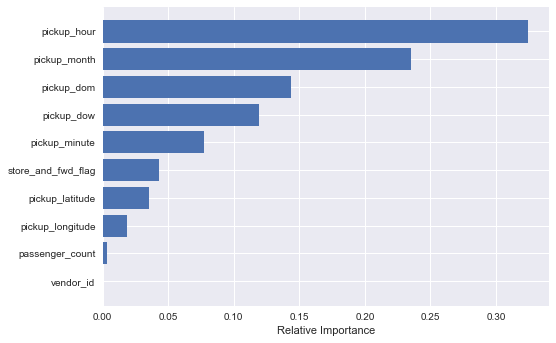

In [18]:
# APPROACHES TO MISSING DATA
#-------------------------------

# # Test the approaches to missing data

df_test = df.drop(['id','pickup_datetime','dropoff_datetime','pickup_weekday','manhattan_distance'], axis = 1)
df_test = df_test.head(100000)

# # Call function to clean missing data

# # Approach 1 - delete rows containing missing values 
test_pred1, rows_dropped = approach1_rem_msg(df_test)

# # Get performance measure of Approach 1
test_pred1_logistic_accuracy = accuracy_determination(test_pred1,"Logistic Regression",'trip_duration_encoded')
test_pred1_rf_accuracy = accuracy_determination(test_pred1,"Random Forests",'trip_duration_encoded')

# #----------------------------------------------------------------------------------------------------------------------------

# # Approach 2 - Impute missing values

# # Part a - Impute with mean
test_pred2a, imputed_values2a = approach2_impute_metric(df_test,"mean",['dropoff_longitude','pickup_hour'])
# # Get performance measure of Approach 2a
test_pred2a_logistic_accuracy = accuracy_determination(test_pred2a,"Logistic Regression",'trip_duration_encoded')
test_pred2a_rf_accuracy = accuracy_determination(test_pred2a,"Random Forests",'trip_duration_encoded')

# # Part b - Impute with median
test_pred2b, imputed_values2b = approach2_impute_metric(df_test,"median",['dropoff_longitude','pickup_hour'])
# # Get performance measure of Approach 2b
test_pred2b_logistic_accuracy = accuracy_determination(test_pred2b,"Logistic Regression",'trip_duration_encoded')
test_pred2b_rf_accuracy = accuracy_determination(test_pred2b,"Random Forests",'trip_duration_encoded')

# # Part c - Impute with mode
test_pred2c, imputed_values2c = approach2_impute_metric(df_test,"mode",['dropoff_longitude','pickup_hour'])
# # Get performance measure of Approach 2c
test_pred2c_logistic_accuracy = accuracy_determination(test_pred2c,"Logistic Regression",'trip_duration_encoded')
test_pred2c_rf_accuracy = accuracy_determination(test_pred2c,"Random Forests",'trip_duration_encoded')

#---------------------------------------------------------------------------------------------------------------------------

# # Approach 3 - Predict missing values

# #Part a - Predict using linear regression
test_pred3a, predicted_values3a = approach3_predict_msg(df_test,"Linear Regression",['dropoff_longitude','pickup_hour'])
# # Get performance measure of Approach 3a
test_pred3a_logistic_accuracy = accuracy_determination(test_pred3a,"Logistic Regression",'trip_duration_encoded')
test_pred3a_rf_accuracy = accuracy_determination(test_pred3a,"Random Forests",'trip_duration_encoded')

# Part b - Predict using Random Forests
test_pred3b, predicted_values3b = approach3_predict_msg(df_test,"Random Forests",['dropoff_longitude','pickup_hour'])
# # Get performance measure of Approach 3b
test_pred3b_logistic_accuracy = accuracy_determination(test_pred3b,"Logistic Regression",'trip_duration_encoded')
test_pred3b_rf_accuracy = accuracy_determination(test_pred3b,"Random Forests",'trip_duration_encoded')

In [27]:
comparisons_df = pd.DataFrame(columns = ['Approach', 'Accuracy - Logistic Regression', 'Accuracy - Random Forests'],
                              data =[['Remove missing rows',test_pred1_logistic_accuracy,test_pred1_rf_accuracy],
                                     ['Impute - mean',test_pred2a_logistic_accuracy,test_pred2a_rf_accuracy],
                                     ['Impute - median',test_pred2b_logistic_accuracy,test_pred2b_rf_accuracy],
                                     ['Impute - mode',test_pred2c_logistic_accuracy,test_pred2c_rf_accuracy],
                                     ['Predict - Linear Regression',test_pred3a_logistic_accuracy,test_pred3a_rf_accuracy],
                                     ['Predict - Random Forests',test_pred3b_logistic_accuracy,test_pred3b_rf_accuracy]])
comparisons_df

,Approach,Accuracy - Logistic Regression,Accuracy - Random Forests
0,Remove missing rows,0.822191,0.860597
1,Impute - mean,0.817000,0.853750
2,Impute - median,0.817000,0.852000
3,Impute - mode,0.817000,0.853500
4,Predict - Linear Regression,0.817000,0.854250
5,Predict - Random Forests,0.817000,0.853000


In [ ]:
# Compare missing value replacement approaches 

In [ ]:
from ipywidgets import *
from IPython.display import display
from IPython.display import clear_output
import matplotlib.pyplot as plt
import missingno as msno

mean_pickup = test_pred2a['pickup_hour'].mean()
mean_dropoff = test_pred2a['dropoff_longitude'].mean()
median_pickup = test_pred2b['pickup_hour'].median()
median_dropoff = test_pred2b['dropoff_longitude'].median()
mode_pickup = test_pred2c['pickup_hour'].mode()
mode_dropoff = test_pred2c['dropoff_longitude'].mode()

# make 4 buttons
button1 = Button(description="Delete rows with missing values",
           layout=Layout(width='50%', height='50px'))
button2 = Button(description="Impute metric: Mean",
                layout=Layout(width='50%', height='50px'))
button3 = Button(description="Impute metric: Median",
                layout=Layout(width='50%', height='50px'))
button4 = Button(description="Impute metric: Mode",
                layout=Layout(width='50%', height='50px'))
button5 = Button(description="Predict values: Linear Regression",
                layout=Layout(width='50%', height='50px'))
button6 = Button(description="Predict values: Random Forests",
                layout=Layout(width='50%', height='50px'))
display(button1, button2, button3, button4, button5, button6)

# define button calls

def button1Clicked(b):
    clear_output()
    msno.matrix(df)
    msno.matrix(test_pred1)
    
def button2Clicked(b):
    clear_output()
    
    plt.figure(figsize=(12, 6))  
    
    plt.subplot(1, 2, 1)
 #   plt.title("Mean Pickup Hour: "+str(round(mean_pickup,2)), fontsize=22)
    plt.hist(test_pred2a['pickup_hour'], 15, color="#2980B9", alpha=0.6)
    plt.ylabel("Frequency", fontsize=16) 
    plt.xlabel("Pickup Hour", fontsize=16)
    plt.axvspan(mean_pickup-.5, mean_pickup+.5, color='red', alpha=0.5)
    
    plt.subplot(1, 2, 2)
  #  plt.title("Mean Dropoff Longitude: "+str(round(mean_dropoff,2)), fontsize=22)
    plt.hist(test_pred2a['dropoff_longitude'], 10, range=[-74.4, -73.6], color="#FBC02D", alpha=0.6)
    plt.ylabel("Frequency", fontsize=16) 
    plt.xlabel("Dropoff Longitude", fontsize=16)
    plt.axvspan(mean_dropoff-.015, mean_dropoff+.015, color='red', alpha=0.5)
    
    plt.tight_layout()
    
    # plt.savefig('impute_mean.png', bbox_inches='tight')
    plt.show()
    
def button3Clicked(b):
    clear_output()
    
    plt.figure(figsize=(12, 6))  
    
    plt.subplot(1, 2, 1)
    plt.title("Median Pickup Hour: "+str(round(median_pickup,2)), fontsize=22)
    plt.hist(test_pred2b['pickup_hour'], 15, color="#2980B9", alpha=0.6)
    plt.ylabel("Frequency", fontsize=16) 
    plt.xlabel("Pickup Hour", fontsize=16)
    plt.axvspan(median_pickup-.5, median_pickup+.5, color='red', alpha=0.5)
    
    plt.subplot(1, 2, 2)
    plt.title("Median Dropoff Longitude: "+str(round(mean_dropoff,2)), fontsize=22)
    plt.hist(test_pred2b['dropoff_longitude'], 10, range=[-74.5, -73.5], color="#FBC02D", alpha=0.6)
    plt.ylabel("Frequency", fontsize=16) 
    plt.xlabel("Dropoff Longitude", fontsize=16)
    plt.axvspan(median_dropoff-.015, median_dropoff+.015, color='red', alpha=0.5)
    
    plt.tight_layout()
    
    # plt.savefig('impute_median.png', bbox_inches='tight')
    plt.show()
    
def button4Clicked(b):
    clear_output()
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Modal Pickup Hour: "+str(round(mode_pickup[0],2)), fontsize=22)
    plt.hist(test_pred2c['pickup_hour'], 24, color="#2980B9", alpha=0.6)
    plt.ylabel("Frequency", fontsize=16) 
    plt.xlabel("Pickup Hour", fontsize=16)
    plt.axvspan(mode_pickup[0]-.5, mode_pickup[0]+.5, color='red', alpha=0.5)
    
    plt.subplot(1, 2, 2)
    plt.title("Modal Dropoff Longitude: "+str(round(mode_dropoff[0],2)), fontsize=22)
    plt.hist(test_pred2c['dropoff_longitude'], 10, range=[-74.5, -73.5], color="#FBC02D", alpha=0.6)
    plt.ylabel("Frequency", fontsize=16) 
    plt.xlabel("Dropoff Longitude", fontsize=16)
    plt.axvspan(mode_dropoff[0]-.015, mode_dropoff[0]+.015, color='red', alpha=0.5)
    
    plt.tight_layout()
    
    # plt.savefig('impute_mode.png', bbox_inches='tight')
    
    plt.show()

def button5Clicked(b):
    clear_output()
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Pickup Hour with Linear Regression", fontsize=22)
    plt.hist(predicted_values3a[1], 15, color="#795548", alpha=0.6)
    plt.ylabel("Frequency", fontsize=16) 
    plt.xlabel("Pickup Hour", fontsize=16)
    
    plt.subplot(1, 2, 2)
    plt.title("Dropoff Longitude with Linear Regression", fontsize=22)
    plt.hist(predicted_values3a[0], 15, color="#2980B9", alpha=0.6)
    plt.ylabel("Frequency", fontsize=16) 
    plt.xlabel("Pickup Hour", fontsize=16)
    
    plt.tight_layout()
    
    plt.savefig('lin_regression.png', bbox_inches='tight')
    
    plt.show()

def button6Clicked(b):
    clear_output()
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Pickup Hour with Random Forests", fontsize=22)
    plt.hist(predicted_values3b[1], 15, color="#8BC34A", alpha=0.6)
    plt.ylabel("Frequency", fontsize=16) 
    plt.xlabel("Pickup Hour", fontsize=16)
    
    plt.subplot(1, 2, 2)
    plt.title("Dropoff Longitude with Random Forests", fontsize=22)
    plt.hist(predicted_values3b[0], 15, color="#FB8C00", alpha=0.6)
    plt.ylabel("Frequency", fontsize=16) 
    plt.xlabel("Pickup Hour", fontsize=16)
    
    plt.tight_layout()
    
    plt.savefig('random_forests.png', bbox_inches='tight')
    
    plt.show()
    
# specify which functions to be called when buttons are clicked
button1.on_click(button1Clicked)
button2.on_click(button2Clicked)
button3.on_click(button3Clicked)
button4.on_click(button4Clicked)
button5.on_click(button5Clicked)
button6.on_click(button6Clicked)